In [44]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
import tensorflow as tf
import matplotlib.cm as cm

In [45]:
# 최상위 밀집 연결 층을 포함
model = keras.applications.xception.Xception(weights='imagenet')

In [46]:
img_path = keras.utils.get_file(
    fname='elephant.jpg',
    origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')

In [47]:
def get_img_array(img_path, target_size) :
    # 이미지를 target_size로 가져옴
    # 299 * 299 크기의 PIL(Python Imaging Library) 이미지를 반환
    img = keras.utils.load_img(img_path, target_size=target_size)
    # 이미지를 (target_size, target_size, 3) 크기의 배열로 반환
    array = keras.utils.img_to_array(img)
    # 배열을 (1, 299, 299, 3) 크기의 배치로 변환하기 위해 차원을 추가
    array = np.expand_dims(array, axis=0)
    # 배치를 전처리(채널별 컬러 정규화)함
    # 입력 값을 127.5로 나눈 후 1을 빼서 -1~1 사이로 정규화
    array = keras.applications.xception.preprocess_input(array)
    return array

In [48]:
img_array = get_img_array(img_path, target_size=(299, 299))

In [49]:
img_array

array([[[[ 0.54509807,  0.69411767,  0.827451  ],
         [ 0.5529412 ,  0.7019608 ,  0.8352941 ],
         [ 0.5529412 ,  0.7019608 ,  0.8352941 ],
         ...,
         [ 0.5058824 ,  0.62352943,  0.77254903],
         [ 0.5058824 ,  0.62352943,  0.77254903],
         [ 0.5058824 ,  0.62352943,  0.77254903]],

        [[ 0.5529412 ,  0.7019608 ,  0.8352941 ],
         [ 0.54509807,  0.69411767,  0.827451  ],
         [ 0.56078434,  0.70980394,  0.84313726],
         ...,
         [ 0.5058824 ,  0.62352943,  0.77254903],
         [ 0.5137255 ,  0.6313726 ,  0.78039217],
         [ 0.5137255 ,  0.6313726 ,  0.78039217]],

        [[ 0.5529412 ,  0.7019608 ,  0.8352941 ],
         [ 0.56078434,  0.70980394,  0.84313726],
         [ 0.56078434,  0.70980394,  0.84313726],
         ...,
         [ 0.5137255 ,  0.6392157 ,  0.7647059 ],
         [ 0.5058824 ,  0.6313726 ,  0.75686276],
         [ 0.5137255 ,  0.6392157 ,  0.7647059 ]],

        ...,

        [[-0.30196077, -0.25490195, -0

In [50]:
preds = model.predict(img_array)
# 예측 결과에서 top 매개변수에 지정된 개수의 최상위 3개 항목을 클래스 레이블과 함께 반환
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 406ms/step
[('n02504458', 'African_elephant', 0.8697782), ('n01871265', 'tusker', 0.07703389), ('n02504013', 'Indian_elephant', 0.02360104)]


In [51]:
# 아프리카 코끼리는 386번 인덱스
np.argmax(preds)

386

In [52]:
# 입력 이미지를 마지막 합성곱 층의 활성화에 매핑하는 모델
# Xception 모델의 마지막 conv 층의 이름
last_conv_layer_name = 'block14_sepconv2_act'
# 분류기(밀집 신경망) 층 이름
Classifier_layer_names = [
    'avg_pool',
    'predictions',
]
# 마지막 conv층을 가져옴
last_conv_layer = model.get_layer(last_conv_layer_name)
# Xception의 input과 마지막 conv층을 이용하여 새로운 모델을 생성
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [53]:
last_conv_layer.output[0].shape

TensorShape([10, 10, 2048])

In [54]:
# 마지막 합성곱 층의 활성화를 최종 클래스 예측에 매핑하는 모델
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in Classifier_layer_names :
    # 최상위 밀집 신경망 층을 위에서 저장한 이름을 이용해 쌓음
    x = model.get_layer(layer_name)(x)
# x를 output으로 이용하여 모델을 생성
classifier_model = keras.Model(classifier_input, x)

In [55]:
classifier_model.output.shape

TensorShape([None, 1000])

In [56]:
# 마지막 합성곱 층의 활성화에 대한 최상위 예측 클래스의 그레이디언트를 계산

with tf.GradientTape() as tape :
    # 마지막 합성곱 층의 활성화를 계산
    last_conv_layer_output = last_conv_layer_model(img_array)
    # 그레이디언트 테이프에 감시 대상에 추가
    tape.watch(last_conv_layer_output)
    # 마지막 합성곱 층의 활성화를 최종 클래스 예측에 매핑하는 모델
    preds = classifier_model(last_conv_layer_output)
    # 최종 예측 클래스를 추출
    top_pred_index = tf.argmax(preds[0])
    # 활성화 채널을 추출
    top_class_channel = preds[:, top_pred_index]

# 마지막 합성곱 층의 출력 특성 맵에 대한 최상위 예측 클래스의 그레이디언트를 계산
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [57]:
# 그레이디언트 텐서를 평균하고 중요도 가중치를 적용하여 클래스 활성화 히트맵을 만듦

# 이 벡터의 각 원소는 어떤 채널에 대한 그레이디언트의 평균 강도
# 최상위 예측 클래스에 대한 각 채널의 중요도를 정량화한 것
# 0, 1, 2차원을 제거하고 채널만을 남겨서 평균을 계산
# (2048,)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
# (10, 10, 2048)
last_conv_layer_output = last_conv_layer_output.numpy()[0]
# 마지막 합성곱 층의 출력에 있는 각 채널에 채널의 중요도를 곱함
for i in range(pooled_grads.shape[-1]) :
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
# 만들어진 특성 맵을 채널별로 평균하면 클래스 활성화 히트맵이 됨
heatmap = np.mean(last_conv_layer_output, axis=-1)

In [58]:
last_conv_layer_output.shape

(10, 10, 2048)

In [59]:
heatmap.shape

(10, 10)

In [60]:
pooled_grads.shape

(2048,)

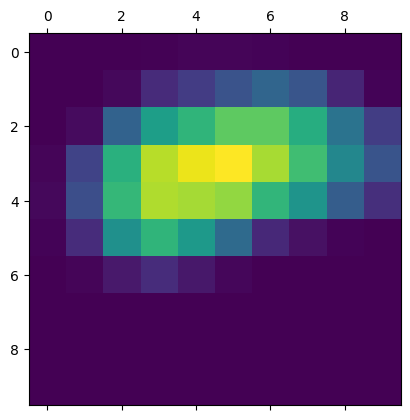

In [61]:
# 시각화를 위해 히트맵을 0과 1사이로 정규화
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [62]:
# 앞에서 얻은 히트맵에 원본 그림을 겹친 이미지를 만듦

# 원본 이미지를 로드
img = keras.utils.load_img(img_path)
# 이미지를 배열로 변경
img = keras.utils.img_to_array(img)
# 히트맵을 0 ~ 255 범위로 조정
heatmap = np.uint8(255 * heatmap)

# jet 컬러맵을 사용하여 히트맵의 색을 바꿈
jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# 새로운 히트맵을 담을 이미지를 만듦
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# 히트맵에 40% 투명도를 주고 원본 이미지를 합침
superimosed_img = jet_heatmap * 0.4 + img
superimosed_img = keras.utils.array_to_img(superimosed_img)

# 합친 이미지를 저장
save_path = 'elephant_cam.jpg'
superimosed_img.save(save_path)

C:\Users\KSY\AppData\Local\Temp\ipykernel_21384\369631780.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')
